# Q1:

## 1. Data Preparation & Tokenization:

In [167]:
import os
import sentencepiece as spm
from torch.utils.data import Dataset, DataLoader
import torch

# 1.1 Reading parallel corpus
def read_parallel(src_path, tgt_path):
    with open(src_path, 'r', encoding='utf-8') as f_src, \
         open(tgt_path, 'r', encoding='utf-8') as f_tgt:
        src_lines = [line.strip() for line in f_src]
        tgt_lines = [line.strip() for line in f_tgt]
    assert len(src_lines) == len(tgt_lines), "Alignment mismatch"  
    return src_lines, tgt_lines


train_en, train_ur = read_parallel('/kaggle/input/quran-dataset/train.en', '/kaggle/input/quran-dataset/train.ur')
dev_en, dev_ur     = read_parallel('/kaggle/input/quran-dataset/dev.en',   '/kaggle/input/quran-dataset/dev.ur')
test_en, test_ur   = read_parallel('/kaggle/input/quran-dataset/test.en',  '/kaggle/input/quran-dataset/test.ur')


# 1.2 SentencePiece BPE model
spm.SentencePieceTrainer.Train('--input=/kaggle/input/quran-dataset/train.en --model_prefix=spm_en --vocab_size=8200 --model_type=bpe --num_threads=16')  
spm.SentencePieceTrainer.Train('--input=/kaggle/input/quran-dataset/train.ur --model_prefix=spm_ur --vocab_size=8200 --model_type=bpe --num_threads=16') 
sp_en = spm.SentencePieceProcessor(model_file='spm_en.model')
sp_ur = spm.SentencePieceProcessor(model_file='spm_ur.model')


# 1.3 Dataset class
class TranslationDataset(Dataset):
    def __init__(self, src_lines, tgt_lines, sp_src, sp_tgt, max_len=128):
        self.src = src_lines; self.tgt = tgt_lines
        self.sp_src = sp_src; self.sp_tgt = sp_tgt
        self.max_len = max_len

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src_ids = self.sp_src.encode(self.src[idx])[:self.max_len-2]
        tgt_ids = self.sp_tgt.encode(self.tgt[idx])[:self.max_len-2]
        return {
            'src': torch.tensor([1] + src_ids + [2]),  # 1=SOS, 2=EOS
            'tgt': torch.tensor([1] + tgt_ids + [2])
        }

train_ds = TranslationDataset(train_en, train_ur, sp_en, sp_ur)
dev_ds   = TranslationDataset(dev_en,   dev_ur,   sp_en, sp_ur)
test_ds  = TranslationDataset(test_en,  test_ur,  sp_en, sp_ur)

def collate_fn(batch):
    src = [b['src'] for b in batch]
    tgt = [b['tgt'] for b in batch]
    src = torch.nn.utils.rnn.pad_sequence(src, padding_value=0, batch_first=True)
    tgt = torch.nn.utils.rnn.pad_sequence(tgt, padding_value=0, batch_first=True)
    return src, tgt

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)  
dev_loader   = DataLoader(dev_ds,   batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, collate_fn=collate_fn)


In [168]:
len(train_loader)

94

## 2.1 Transformer:

In [169]:
import math
from torch import nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)]
        return x


class TransformerMT(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, d_model=512, nhead=8,
                 num_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.src_tok = nn.Embedding(src_vocab, d_model)
        self.tgt_tok = nn.Embedding(tgt_vocab, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(
            d_model, nhead, num_layers, num_layers,
            dim_feedforward, dropout
        )
        self.fc_out = nn.Linear(d_model, tgt_vocab)

    def forward(self, src, tgt):
        
        # src: (batch, src_len), tgt: (batch, tgt_len)
        # embedding + positional encoding, then transpose to (seq_len, batch, d_model)
        
        src_emb = self.pos_enc(self.src_tok(src).transpose(0, 1))
        tgt_emb = self.pos_enc(self.tgt_tok(tgt).transpose(0, 1))

        # building causal mask for tgt
        tgt_seq_len = tgt_emb.size(0)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(
            tgt_seq_len,
            device=src.device,
            dtype=tgt_emb.dtype
        )

        out = self.transformer(
            src_emb,
            tgt_emb,
            tgt_mask=tgt_mask
        )
        
        return self.fc_out(out).transpose(0, 1)


## 2.2 LSTM with Bahdanau Attention:

In [180]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from tqdm import trange, tqdm
import numpy as np
import sacrebleu
from rouge import Rouge


class BahdanauAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        
        self.W1 = nn.Linear(enc_dim, enc_dim)  
        self.W2 = nn.Linear(dec_dim, enc_dim)  
        self.V  = nn.Linear(enc_dim, 1)

    def forward(self, dec_hidden, enc_outputs):
       
        proj_enc = self.W1(enc_outputs)                    
        proj_dec = self.W2(dec_hidden).unsqueeze(1)       
        score    = self.V(torch.tanh(proj_enc + proj_dec)) 
        weights  = torch.softmax(score, dim=1)             
        context  = (weights * enc_outputs).sum(dim=1)      
        return context, weights


class Seq2SeqLSTM(nn.Module):
    def __init__(self, src_vocab, tgt_vocab,
                 embed_size=256, hidden_size=512, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding_src = nn.Embedding(src_vocab, embed_size)
        self.embedding_tgt = nn.Embedding(tgt_vocab, embed_size)

        # bidirectional encoder
        self.encoder = nn.LSTM(
            embed_size, hidden_size, num_layers,
            batch_first=True, bidirectional=True, dropout=dropout
        )
        enc_dim = hidden_size * 2

        # project encoder's final state into decoder's hidden_size
        self.init_hidden = nn.Linear(enc_dim, hidden_size)
        self.init_cell   = nn.Linear(enc_dim, hidden_size)

        # attention now knows both dims
        self.attn    = BahdanauAttention(enc_dim, hidden_size)
        self.decoder = nn.LSTM(
            embed_size + enc_dim, hidden_size,
            num_layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_size + enc_dim, tgt_vocab)

    def forward(self, src, tgt):
        # encoding
        enc_emb, _ = self.encoder(self.embedding_src(src))
        last_enc   = enc_emb[:, -1, :]  # (batch, enc_dim)

        # initializing decoder hidden/cell
        h0 = torch.tanh(self.init_hidden(last_enc))
        c0 = torch.tanh(self.init_cell(last_enc))
        
        h0 = h0.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        c0 = c0.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)

        dec_h, dec_c = h0, c0
        outputs = []
        
        for t in range(tgt.size(1)):
            emb_t      = self.embedding_tgt(tgt[:, t]).unsqueeze(1)
            context, _ = self.attn(dec_h[-1], enc_emb)
            dec_in     = torch.cat([emb_t, context.unsqueeze(1)], dim=2)
            out, (dec_h, dec_c) = self.decoder(dec_in, (dec_h, dec_c))
            pred = self.fc(torch.cat([out.squeeze(1), context], dim=1))
            outputs.append(pred.unsqueeze(1))

        return torch.cat(outputs, dim=1)


## 3. Training Loop & Hyperparameters:

### Transformer Training:

In [184]:
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from tqdm import trange
from tqdm import tqdm

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for src, tgt in tqdm(loader, desc="  Training", leave=False):
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt[:, :-1])
        loss = criterion(
            output.reshape(-1, output.size(-1)),
            tgt[:, 1:].reshape(-1)
        )
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    
    for src, tgt in tqdm(loader, desc="  Evaluating", leave=False):
        src, tgt = src.to(device), tgt.to(device)
        with torch.no_grad():
            output = model(src, tgt[:, :-1])
            loss = criterion(
                output.reshape(-1, output.size(-1)),
                tgt[:, 1:].reshape(-1)
            )
        total_loss += loss.item()
    return total_loss / len(loader)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer = TransformerMT(len(sp_en), len(sp_ur)).to(device)
lstm_model  = Seq2SeqLSTM(len(sp_en), len(sp_ur)).to(device)


opt_t = optim.Adam(transformer.parameters(), lr=1e-4)
opt_l = optim.Adam(lstm_model.parameters(), lr=5e-4)
crit = nn.CrossEntropyLoss(ignore_index=0)


In [185]:
# Translate batch utility (for BLEU/accuracy)
def translate_batch(model, loader, sp_src, sp_tgt, device, max_len=128):
    model.eval()
    refs, hyps = [], []
    sos, eos = 1, 2
    with torch.no_grad():
        for src, tgt in loader:
            src = src.to(device)
            
            for r in tgt.cpu().tolist():
                refs.append(sp_tgt.decode_ids(r[1:-1]))
            
            batch_size = src.size(0)
            dec = torch.full((batch_size,1), sos, dtype=torch.long, device=device)
            for _ in range(max_len-1):
                logits = model(src, dec)
                next_tok = logits[:,-1,:].argmax(-1, keepdim=True)
                dec = torch.cat([dec, next_tok], dim=1)
                if (next_tok==eos).all(): break
            for seq in dec.cpu().tolist():
                if eos in seq:
                    seq = seq[:seq.index(eos)]
                hyps.append(sp_tgt.decode_ids(seq[1:]))
    return refs, hyps


# Inference speed measurement
def measure_inference_speed(model, loader, device, warmup=2):
    model.eval()
    timings = []
    with torch.no_grad():
        for i,(src,tgt) in enumerate(loader):
            if i<warmup:
                _ = model(src.to(device), tgt[:,:-1].to(device))
                continue
            src, tgt = src.to(device), tgt.to(device)
            if device.type=='cuda': torch.cuda.synchronize()
            t0 = time.time()
            _ = model(src, tgt[:,:-1])
            if device.type=='cuda': torch.cuda.synchronize()
            t1 = time.time()
            timings.append((t1-t0)*1000/src.size(0))
    return float(np.mean(timings))


train_losses, val_losses = [], []
train_times, train_mems = [], []
perplexities, val_accs, inf_speeds = [], [], []

best_val, wait = float('inf'), 0
patience = 5

for ep in trange(1, 51, desc="LSTM Epochs"):
    torch.cuda.reset_max_memory_allocated()
    t0 = time.time()
    tr_loss = train_epoch(transformer, train_loader, opt_t, crit, device)
    tr_time = time.time() - t0
    tr_mem  = torch.cuda.max_memory_allocated() / (1024**2)

    val_loss = eval_epoch(transformer, dev_loader, crit, device)
    val_ppl  = torch.exp(torch.tensor(val_loss)).item()

    refs, hyps = translate_batch(transformer, dev_loader, sp_en, sp_ur, device)
    acc = sum(r.strip()==h.strip() for r,h in zip(refs,hyps)) / len(refs) * 100

    inf_speed = measure_inference_speed(transformer, dev_loader, device)

    print(f"[LSTM ep{ep:02d}] tr={tr_loss:.3f} val={val_loss:.3f} | "
          f"ppl={val_ppl:.1f}% acc={acc:.2f}% | "
          f"time={tr_time:.1f}s mem={tr_mem:.1f}MB inf={inf_speed:.2f}ms/s")

    if val_loss < best_val:
        best_val, wait = val_loss, 0
        torch.save(lstm.state_dict(), 'best_transformer_2.pt')
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_times.append(tr_time)
    train_mems.append(tr_mem)
    perplexities.append(val_ppl)
    val_accs.append(acc)
    inf_speeds.append(inf_speed)

  Training: 100%|██████████| 94/94 [01:11<00:00,  1.37it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00, 10.06it/s]
                                                           

[LSTM ep01] tr=6.541 val=5.877 | ppl=356.6% acc=0.00% | time=71.2s mem=7603.7MB inf=1.51ms/s


  Training: 100%|██████████| 94/94 [01:16<00:00,  1.28it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.33it/s]
                                                           

[LSTM ep02] tr=5.266 val=5.380 | ppl=217.0% acc=0.00% | time=76.2s mem=7603.7MB inf=1.54ms/s


LSTM Epochs:   4%|▍         | 2/50 [05:12<2:05:01, 156.28s/it]


KeyboardInterrupt: 

In [ ]:
best_val = float('inf')
patience = 5; wait = 0
for epoch in trange(1, 51, desc="Epochs"):
    tr_loss = train_epoch(transformer, train_loader, opt_t, crit, device) 
    val_loss= eval_epoch(transformer, dev_loader,   crit, device)
    print(f"[Trans ep{epoch}] tr={tr_loss:.3f} val={val_loss:.3f}")
    if val_loss < best_val:
        best_val, wait = val_loss, 0
        torch.save(transformer.state_dict(), 'best_transformer_2.pt')
    else:
        wait += 1
        if wait >= patience: break


  Training: 100%|██████████| 94/94 [01:12<00:00,  1.36it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00, 10.12it/s]
                                                           

[Trans ep1] tr=6.556 val=5.867


  Training: 100%|██████████| 94/94 [01:15<00:00,  1.29it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.55it/s]
                                                           

[Trans ep2] tr=5.246 val=5.306


  Training: 100%|██████████| 94/94 [01:17<00:00,  1.28it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.50it/s]
                                                           

[Trans ep3] tr=4.781 val=5.264


  Training: 100%|██████████| 94/94 [01:17<00:00,  1.28it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.36it/s]
                                                           

[Trans ep4] tr=4.511 val=5.116


  Training: 100%|██████████| 94/94 [01:18<00:00,  1.31it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.27it/s]
                                                           

[Trans ep5] tr=4.313 val=4.944


  Training: 100%|██████████| 94/94 [01:18<00:00,  1.25it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.35it/s]
                                                           

[Trans ep6] tr=4.158 val=4.935


  Training: 100%|██████████| 94/94 [01:18<00:00,  1.29it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.37it/s]
                                                           

[Trans ep7] tr=4.021 val=4.816


  Training: 100%|██████████| 94/94 [01:19<00:00,  1.30it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.34it/s]
                                                           

[Trans ep8] tr=3.891 val=4.814


  Training: 100%|██████████| 94/94 [01:18<00:00,  1.32it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.39it/s]
                                                           

[Trans ep9] tr=3.773 val=4.624


  Training: 100%|██████████| 94/94 [01:18<00:00,  1.26it/s]
                                                           
Epochs:  20%|██        | 10/50 [13:03<52:53, 79.33s/it]    

[Trans ep10] tr=3.662 val=4.788



  Training: 100%|██████████| 94/94 [01:19<00:00,  1.27it/s]
                                                           
Epochs:  22%|██▏       | 11/50 [14:22<51:34, 79.35s/it]    

[Trans ep11] tr=3.557 val=4.732



  Training: 100%|██████████| 94/94 [01:18<00:00,  1.27it/s]
                                                           
Epochs:  24%|██▍       | 12/50 [15:42<50:12, 79.29s/it]    

[Trans ep12] tr=3.459 val=4.671



  Training: 100%|██████████| 94/94 [01:19<00:00,  1.31it/s]
                                                           
Epochs:  26%|██▌       | 13/50 [17:01<48:54, 79.32s/it]    

[Trans ep13] tr=3.367 val=4.681



  Training: 100%|██████████| 94/94 [01:18<00:00,  1.26it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.29it/s]
                                                           

[Trans ep14] tr=3.271 val=4.560


  Training: 100%|██████████| 94/94 [01:19<00:00,  1.30it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.32it/s]
                                                           

[Trans ep15] tr=3.182 val=4.537


  Training: 100%|██████████| 94/94 [01:19<00:00,  1.26it/s]
                                                           
Epochs:  32%|███▏      | 16/50 [21:01<45:14, 79.83s/it]    

[Trans ep16] tr=3.086 val=4.557



  Training: 100%|██████████| 94/94 [01:18<00:00,  1.36it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.29it/s]
                                                           

[Trans ep17] tr=2.995 val=4.417


  Training: 100%|██████████| 94/94 [01:18<00:00,  1.39it/s]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  9.30it/s]
                                                           

[Trans ep18] tr=2.911 val=4.310


  Training: 100%|██████████| 94/94 [01:18<00:00,  1.41it/s]
                                                           
Epochs:  38%|███▊      | 19/50 [24:59<41:03, 79.47s/it]    

[Trans ep19] tr=2.821 val=4.418



  Training: 100%|██████████| 94/94 [01:18<00:00,  1.27it/s]
                                                           
Epochs:  40%|████      | 20/50 [26:18<39:41, 79.38s/it]    

[Trans ep20] tr=2.741 val=4.524



  Training: 100%|██████████| 94/94 [01:18<00:00,  1.34it/s]
                                                           
Epochs:  42%|████▏     | 21/50 [27:37<38:18, 79.24s/it]    

[Trans ep21] tr=2.657 val=4.438



  Training: 100%|██████████| 94/94 [01:18<00:00,  1.26it/s]
                                                           
Epochs:  44%|████▍     | 22/50 [28:56<36:55, 79.13s/it]    

[Trans ep22] tr=2.579 val=4.519



  Training: 100%|██████████| 94/94 [01:17<00:00,  1.25it/s]
                                                           
Epochs:  44%|████▍     | 22/50 [30:14<38:29, 82.48s/it]    

[Trans ep23] tr=2.497 val=4.468


### LSTM Training:

In [181]:
# Translate batch utility (for BLEU/accuracy)
def translate_batch(model, loader, sp_src, sp_tgt, device, max_len=128):
    model.eval()
    refs, hyps = [], []
    sos, eos = 1, 2
    with torch.no_grad():
        for src, tgt in loader:
            src = src.to(device)
            
            for r in tgt.cpu().tolist():
                refs.append(sp_tgt.decode_ids(r[1:-1]))
            
            batch_size = src.size(0)
            dec = torch.full((batch_size,1), sos, dtype=torch.long, device=device)
            for _ in range(max_len-1):
                logits = model(src, dec)
                next_tok = logits[:,-1,:].argmax(-1, keepdim=True)
                dec = torch.cat([dec, next_tok], dim=1)
                if (next_tok==eos).all(): break
            for seq in dec.cpu().tolist():
                if eos in seq:
                    seq = seq[:seq.index(eos)]
                hyps.append(sp_tgt.decode_ids(seq[1:]))
    return refs, hyps


# Inference speed measurement
def measure_inference_speed(model, loader, device, warmup=2):
    model.eval()
    timings = []
    with torch.no_grad():
        for i,(src,tgt) in enumerate(loader):
            if i<warmup:
                _ = model(src.to(device), tgt[:,:-1].to(device))
                continue
            src, tgt = src.to(device), tgt.to(device)
            if device.type=='cuda': torch.cuda.synchronize()
            t0 = time.time()
            _ = model(src, tgt[:,:-1])
            if device.type=='cuda': torch.cuda.synchronize()
            t1 = time.time()
            timings.append((t1-t0)*1000/src.size(0))
    return float(np.mean(timings))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm = Seq2SeqLSTM(len(sp_en), len(sp_ur)).to(device)
opt  = optim.Adam(lstm.parameters(), lr=5e-4)
crit = nn.CrossEntropyLoss(ignore_index=0)

train_losses, val_losses = [], []
train_times, train_mems = [], []
perplexities, val_accs, inf_speeds = [], [], []

best_val, wait = float('inf'), 0
patience = 5

for ep in trange(1, 51, desc="LSTM Epochs"):
    torch.cuda.reset_max_memory_allocated()
    t0 = time.time()
    tr_loss = train_epoch(lstm, train_loader, opt, crit, device)
    tr_time = time.time() - t0
    tr_mem  = torch.cuda.max_memory_allocated() / (1024**2)

    val_loss = eval_epoch(lstm, dev_loader, crit, device)
    val_ppl  = torch.exp(torch.tensor(val_loss)).item()

    refs, hyps = translate_batch(lstm, dev_loader, sp_en, sp_ur, device)
    acc = sum(r.strip()==h.strip() for r,h in zip(refs,hyps)) / len(refs) * 100

    inf_speed = measure_inference_speed(lstm, dev_loader, device)

    print(f"[LSTM ep{ep:02d}] tr={tr_loss:.3f} val={val_loss:.3f} | "
          f"ppl={val_ppl:.1f}% acc={acc:.2f}% | "
          f"time={tr_time:.1f}s mem={tr_mem:.1f}MB inf={inf_speed:.2f}ms/s")

    if val_loss < best_val:
        best_val, wait = val_loss, 0
        torch.save(lstm.state_dict(), 'best_lstm.pt')
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_times.append(tr_time)
    train_mems.append(tr_mem)
    perplexities.append(val_ppl)
    val_accs.append(acc)
    inf_speeds.append(inf_speed)

  Training: 100%|██████████| 94/94 [03:40<00:00,  1.89s/it]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  4.98it/s]
                                                           

[LSTM ep01] tr=6.169 val=5.884 | ppl=359.4% acc=0.00% | time=220.4s mem=11838.8MB inf=3.16ms/s


  Training: 100%|██████████| 94/94 [03:53<00:00,  2.40s/it]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  4.95it/s]
                                                           

[LSTM ep02] tr=5.339 val=5.410 | ppl=223.6% acc=0.00% | time=233.9s mem=11838.8MB inf=3.20ms/s


  Training: 100%|██████████| 94/94 [03:51<00:00,  2.35s/it]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  4.91it/s]
                                                           

[LSTM ep03] tr=4.817 val=5.055 | ppl=156.8% acc=0.00% | time=231.2s mem=11838.8MB inf=3.24ms/s


  Training: 100%|██████████| 94/94 [04:01<00:00,  2.44s/it]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  4.86it/s]
                                                           

[LSTM ep04] tr=4.397 val=4.693 | ppl=109.2% acc=0.00% | time=241.1s mem=11838.8MB inf=3.23ms/s


  Training: 100%|██████████| 94/94 [03:56<00:00,  2.41s/it]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  4.87it/s]
                                                           

[LSTM ep05] tr=3.979 val=4.532 | ppl=92.9% acc=0.00% | time=236.1s mem=11838.8MB inf=3.26ms/s


  Training: 100%|██████████| 94/94 [03:58<00:00,  2.22s/it]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  4.88it/s]
                                                           

[LSTM ep06] tr=3.586 val=4.331 | ppl=76.0% acc=0.00% | time=238.2s mem=11838.8MB inf=3.20ms/s


  Training: 100%|██████████| 94/94 [03:56<00:00,  2.31s/it]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  4.86it/s]
                                                           

[LSTM ep07] tr=3.241 val=4.249 | ppl=70.0% acc=0.00% | time=236.9s mem=11838.8MB inf=3.24ms/s


  Training: 100%|██████████| 94/94 [04:01<00:00,  2.42s/it]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  4.88it/s]
                                                           

[LSTM ep08] tr=2.928 val=4.162 | ppl=64.2% acc=0.00% | time=241.2s mem=11838.8MB inf=3.25ms/s


  Training: 100%|██████████| 94/94 [03:57<00:00,  2.44s/it]
                                                           
  Evaluating:  75%|███████▌  | 3/4 [00:00<00:00,  4.89it/s]
                                                           

[LSTM ep09] tr=2.623 val=4.129 | ppl=62.1% acc=0.00% | time=237.9s mem=11838.8MB inf=3.20ms/s


  Training: 100%|██████████| 94/94 [03:58<00:00,  2.28s/it]
                                                           
LSTM Epochs:  20%|██        | 10/50 [59:08<3:58:36, 357.91s/it]

[LSTM ep10] tr=2.360 val=4.166 | ppl=64.4% acc=0.00% | time=238.5s mem=11838.8MB inf=3.28ms/s



  Training: 100%|██████████| 94/94 [03:58<00:00,  2.44s/it]
                                                           
LSTM Epochs:  22%|██▏       | 11/50 [1:05:07<3:52:49, 358.20s/it]

[LSTM ep11] tr=2.104 val=4.145 | ppl=63.1% acc=0.00% | time=239.0s mem=11838.8MB inf=3.29ms/s



  Training: 100%|██████████| 94/94 [03:56<00:00,  1.98s/it]
                                                           
LSTM Epochs:  24%|██▍       | 12/50 [1:11:03<3:46:25, 357.51s/it]

[LSTM ep12] tr=1.877 val=4.153 | ppl=63.6% acc=0.00% | time=236.1s mem=11838.8MB inf=3.21ms/s



LSTM Epochs:  24%|██▍       | 12/50 [1:12:00<3:48:00, 360.00s/it]


KeyboardInterrupt: 

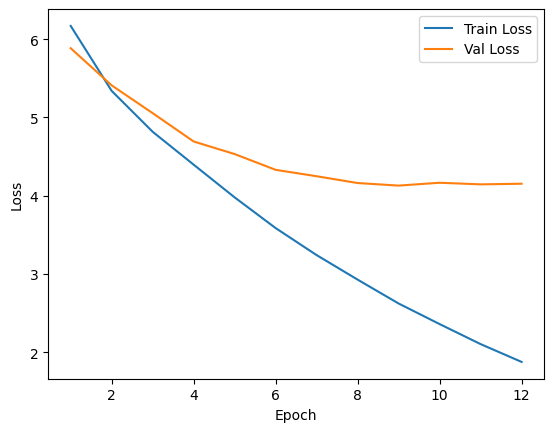

In [182]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

## 4. Evaluation (BLEU, ROUGE, Perplexity):

In [22]:
!pip install sacrebleu
!pip install rouge 

In [29]:
import sacrebleu
from rouge import Rouge

def translate_batch(model, loader, sp_src, sp_tgt, device, max_len=128):
    model.eval()
    refs, hyps = [], []
    sos_id, eos_id = 1, 2

    with torch.no_grad():
        for src, tgt in loader:
            src = src.to(device)

            for ref_ids in tgt.cpu().tolist():
                refs.append(sp_tgt.decode_ids(ref_ids[1:-1]).strip())

            batch_size = src.size(0)
            
            dec_input = torch.full(
                (batch_size, 1),
                fill_value=sos_id,
                dtype=torch.long,
                device=device
            )

            for _ in range(max_len - 1):
                
                logits = model(src, dec_input)
               
                next_token_logits = logits[:, -1, :]        
                next_tokens = next_token_logits.argmax(-1) 
   
                dec_input = torch.cat(
                    [dec_input, next_tokens.unsqueeze(1)],
                    dim=1
                )

                if (next_tokens == eos_id).all():
                    break

            
            for seq in dec_input.cpu().tolist():
                if eos_id in seq:
                    seq = seq[: seq.index(eos_id)]
                hyp_ids = seq[1:]  
                hyps.append(sp_tgt.decode_ids(hyp_ids).strip())

    return refs, hyps


transformer.load_state_dict(torch.load('best_transformer.pt'))
refs, hyps = translate_batch(transformer, test_loader, sp_en, sp_ur, device)

pairs = [(h, r) for h, r in zip(hyps, refs) if h and r]
hyps_f, refs_f = zip(*pairs)

# Computing BLEU
bleu = sacrebleu.corpus_bleu(list(hyps_f), [list(refs_f)])
print("BLEU:", bleu.score)

# Computing ROUGE
rouge = Rouge()
rouge_scores = rouge.get_scores(list(hyps_f), list(refs_f), avg=True)
print("ROUGE:", rouge_scores)

# Perplexity
def perplexity(model, loader, crit, device):
    loss = eval_epoch(model, loader, crit, device)
    return torch.exp(torch.tensor(loss))

print("Transformer Perplexity:", perplexity(transformer, test_loader, crit, device))


/tmp/ipykernel_31/1378941197.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load('best_transformer.pt'))


BLEU: 0.929091533307632
ROUGE: {'rouge-1': {'r': 0.322761657242058, 'p': 0.3030336550435393, 'f': 0.3046248400139588}, 'rouge-2': {'r': 0.06530680964588574, 'p': 0.06106835829981618, 'f': 0.06140184963264858}, 'rouge-l': {'r': 0.28559675939742823, 'p': 0.2670119232092071, 'f': 0.2688358249614572}}


Transformer Perplexity: tensor(86.9357)


## 5. Attention Visualization:

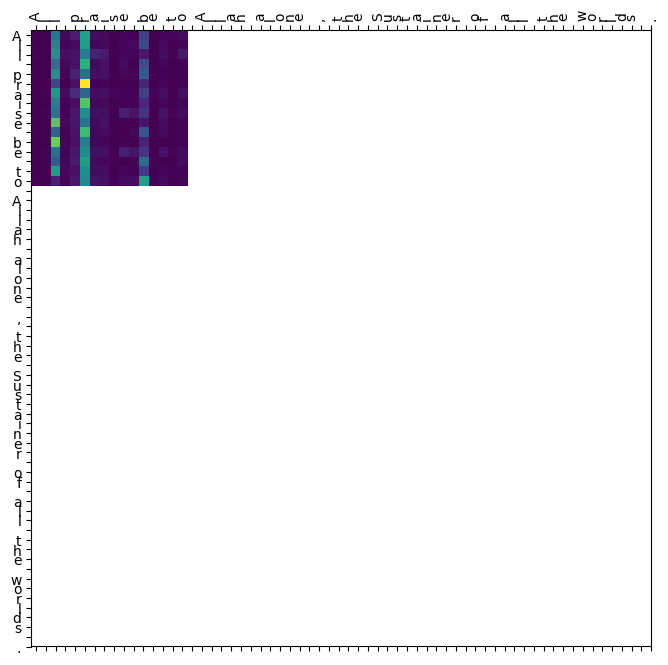

In [34]:
import torch
import matplotlib.pyplot as plt

def plot_attention(attn_weights, src_tokens, head=0):
   
    mat = attn_weights[head].detach().cpu()
    fig, ax = plt.subplots(figsize=(8,8))
    ax.matshow(mat, aspect='auto')
    ax.set_xticks(range(len(src_tokens)))
    ax.set_yticks(range(len(src_tokens)))
    ax.set_xticklabels(src_tokens, rotation=90)
    ax.set_yticklabels(src_tokens)
    plt.show()


sample = train_loader.dataset[0]         
sample_src = sample['src'].unsqueeze(0).to(device)  

src_emb = transformer.pos_enc(
    transformer.src_tok(sample_src).transpose(0,1)
)  

attn_layer = transformer.transformer.encoder.layers[0].self_attn
attn_out, attn_weights = attn_layer(
    src_emb, src_emb, src_emb,
    need_weights=True,
    average_attn_weights=False
)

attn_weights = attn_weights[0]

src_tokens = sp_en.decode_ids(sample_src[0].cpu().tolist())

plot_attention(attn_weights, src_tokens, head=0)


## Deploy:

In [35]:
!pip install pyngrok
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 18.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.9 MB/s eta 0:00:0000:01


In [61]:
%%writefile streamlit_app1.py

import streamlit as st
import torch
import math
from torch import nn
import sentencepiece as spm

# Loading SentencePiece models
sp_en = spm.SentencePieceProcessor(model_file='spm_en.model')
sp_ur = spm.SentencePieceProcessor(model_file='spm_ur.model')

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)]
        return x

class TransformerMT(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, d_model=512, nhead=8,
                 num_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.src_tok = nn.Embedding(src_vocab, d_model)
        self.tgt_tok = nn.Embedding(tgt_vocab, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(
            d_model, nhead, num_layers, num_layers,
            dim_feedforward, dropout
        )
        self.fc_out = nn.Linear(d_model, tgt_vocab)

    def forward(self, src, tgt):
        src_emb = self.pos_enc(self.src_tok(src).transpose(0, 1))
        tgt_emb = self.pos_enc(self.tgt_tok(tgt).transpose(0, 1))

        tgt_seq_len = tgt_emb.size(0)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(
            tgt_seq_len,
            device=src.device,
            dtype=tgt_emb.dtype
        )

        out = self.transformer(
            src_emb,
            tgt_emb,
            tgt_mask=tgt_mask
        )
        
        return self.fc_out(out).transpose(0, 1)


@st.cache_resource

def load_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerMT(
        src_vocab=sp_en.get_piece_size(),
        tgt_vocab=sp_ur.get_piece_size(),
        d_model=512, nhead=8, num_layers=6,
        dim_feedforward=2048, dropout=0.1
    ).to(device)
    model.load_state_dict(torch.load('/kaggle/working/best_transformer.pt', map_location=device))
    model.eval()
    return model, device

model, device = load_model()

if 'history' not in st.session_state:
    st.session_state.history = []

st.title("English → Urdu Translator")

with st.form("translate_form", clear_on_submit=True):
    user_input = st.text_input(
        label="Enter English text:",
        key="input",
        label_visibility="visible",
        placeholder="Type here..."
    )
    submit = st.form_submit_button("Translate")

if submit and user_input:
    
    ids = sp_en.encode(user_input)
    src = torch.tensor([1] + ids + [2], dtype=torch.long).unsqueeze(0).to(device)

    # Greedy decode
    with torch.no_grad():
        dec_input = torch.tensor([[1]], device=device)
        for _ in range(128):
            logits = model(src, dec_input)
            next_id = logits[:, -1, :].argmax(-1)
            dec_input = torch.cat([dec_input, next_id.unsqueeze(1)], dim=1)
            if next_id.item() == 2:
                break
    ur_tokens = dec_input[0].cpu().tolist()[1:]
    if 2 in ur_tokens:
        ur_tokens = ur_tokens[:ur_tokens.index(2)]
    translation = sp_ur.decode_ids(ur_tokens)

    st.session_state.history.append((user_input, translation))

# Rendering conversation history
for en, ur in st.session_state.history:
    st.markdown(f"<div style='text-align: left; padding: 4px;'>{en}</div>", unsafe_allow_html=True)
    st.markdown(f"<div style='text-align: right; padding: 4px; direction: rtl;'>{ur}</div>", unsafe_allow_html=True)



Overwriting streamlit_app1.py


In [ ]:
!ngrok authtoken abc

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml                                


In [62]:
from pyngrok import ngrok

# Start a new ngrok tunnel
public_url = ngrok.connect(8000)

print("Ngrok public URL:", public_url)

Ngrok public URL: NgrokTunnel: "https://59b7-104-154-233-118.ngrok-free.app" -> "http://localhost:8000"


In [63]:
!streamlit run streamlit_app1.py --server.port 8000




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8000
  Network URL: http://172.19.2.2:8000
  External URL: http://104.154.233.118:8000

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/kaggle/working/streamlit_app1.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitr

# Q2:

## 1. Setup & Data Preprocessing:

In [64]:
import time                                                      
import torch                                                    
import torch.nn as nn                                           
import torch.optim as optim                                      
from torch.utils.data import DataLoader, random_split           
import torchvision.transforms as transforms                     
import torchvision.datasets as datasets                          
import torchvision.models as models                             
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,            
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt                                  
import numpy as np                                               
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10 normalization and augmentation:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),                      
    transforms.RandomHorizontalFlip(),                          
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

full_train = datasets.CIFAR10(root='./data', train=True,
                              download=True, transform=train_transform)
test_set   = datasets.CIFAR10(root='./data', train=False,
                              download=True, transform=test_transform)

# Reserving 5k for validation
train_set, val_set = random_split(full_train, [45000, 5000])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=128, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_set,  batch_size=128, shuffle=False, num_workers=4)



100%|██████████| 170M/170M [00:01<00:00, 92.5MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [65]:
len(train_loader)

352

## 2. Model Definitions:

### 2.1 Vision Transformer (ViT):

In [66]:
class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 d_model=256, nhead=4, num_layers=6, mlp_dim=512, dropout=0.1):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2             
        self.patch_dim   = in_chans * patch_size * patch_size
        
        # Linear patch embedding
        self.patch_proj = nn.Linear(self.patch_dim, d_model)   
        
        # Class token + positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_emb   = nn.Parameter(torch.zeros(1, self.num_patches+1, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=mlp_dim,
            dropout=dropout, activation='gelu'
        )                                                             
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        
        # Splitting into patches
        patches = x.unfold(2, 4, 4).unfold(3, 4, 4)                   
        patches = patches.contiguous().view(B, 3, -1, 4, 4)          
        patches = patches.permute(0,2,1,3,4).reshape(B, -1, self.patch_dim)
        
        # Embedding patches and prepending class token
        x = self.patch_proj(patches)                                 
        cls_tokens = self.cls_token.expand(B, -1, -1)                 
        x = torch.cat((cls_tokens, x), dim=1)                        
        x = x + self.pos_emb     
        
        # Transformer
        x = self.transformer(x.transpose(0,1)).transpose(0,1)
        
        # Classification
        return self.mlp_head(x[:,0])


### 2.2 Hybrid CNN + MLP:

In [67]:
class CNN_MLP(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )                                                              
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


### 2.3 ResNet Transfer Learning:

In [68]:
def get_resnet(num_classes=10):
    
    resnet = models.resnet18(pretrained=True)  
    
    for param in resnet.parameters():
        param.requires_grad = False                                 # freezing backbone
    resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
    
    return resnet


## 3. Training & Evaluation Utilities:

In [69]:
from tqdm import tqdm

# Measuring GPU memory
def max_gpu_mem():
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / (1024**2)
    return 0


# Epoch for training or validation
def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    losses, preds, targets = [], [], []
    start = time.time()
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        if is_train:
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        losses.append(loss.item())
        preds.extend(logits.argmax(dim=1).cpu().numpy())
        targets.extend(labels.cpu().numpy())
    duration = time.time() - start
    
    return {
        'loss': np.mean(losses),
        'acc': accuracy_score(targets, preds),
        'precision': precision_recall_fscore_support(targets, preds, average='weighted')[0],
        'recall':    precision_recall_fscore_support(targets, preds, average='weighted')[1],
        'f1':        precision_recall_fscore_support(targets, preds, average='weighted')[2],
        'time': duration * 1000 / len(loader.dataset),   # ms per image
        'mem': max_gpu_mem()
    }


## 4. Main Training Loop:

In [75]:
def train_model(model, name, epochs=20, lr=3e-4):
    model = model.to(device)
    crit  = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=lr)            # 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)
    best_acc, best_weights = 0, None
    history = []
    for ep in tqdm(range(1, epochs+1), desc=f"{name} Epochs", unit="ep"):
        tr = run_epoch(model, train_loader, crit, optim)
        val= run_epoch(model, val_loader,   crit, None)
        scheduler.step()
        history.append((tr, val))
        print(f"{name} Ep{ep}  tr_loss={tr['loss']:.3f} tr_acc={tr['acc']:.3f}  "
              f"val_loss={val['loss']:.3f} val_acc={val['acc']:.3f}  "
              f"precision={tr['precision']:.3f} recall={tr['recall']:.3f}  "
              f"f1={val['f1']:.3f} time={val['time']:.3f} memory={val['mem']:.3f}")
        if val['acc'] > best_acc:
            best_acc = val['acc']; best_weights = model.state_dict()
    model.load_state_dict(best_weights)
    torch.save(best_weights, f"best_{name}.pt")
    return history, model


## 5. Run & Compare:

In [76]:
# Instantiating models
vit      = ViT()
cnn_mlp  = CNN_MLP()
resnet_tl= get_resnet()

# Training
hist_vit,      vit      = train_model(vit,      'vit',      epochs=30, lr=1e-3)
hist_cnn_mlp,  cnn_mlp  = train_model(cnn_mlp,  'cnn_mlp',  epochs=30, lr=1e-3)
hist_resnet,   resnet_tl= train_model(resnet_tl,'resnet',   epochs=20, lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
vit Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]/usr/local/lib/python3.11/dist-packages/sklearn

vit Ep1  tr_loss=1.910 tr_acc=0.270  val_loss=1.877 val_acc=0.295  precision=0.265 recall=0.270  f1=0.235 time=0.253 memory=8700.589


vit Epochs:   7%|▋         | 2/30 [01:04<15:03, 32.27s/ep]

vit Ep2  tr_loss=1.695 tr_acc=0.360  val_loss=1.594 val_acc=0.398  precision=0.355 recall=0.360  f1=0.360 time=0.255 memory=8700.589


vit Epochs:  10%|█         | 3/30 [01:37<14:41, 32.65s/ep]

vit Ep3  tr_loss=1.599 tr_acc=0.407  val_loss=1.574 val_acc=0.419  precision=0.400 recall=0.407  f1=0.402 time=0.273 memory=8700.589


vit Epochs:  13%|█▎        | 4/30 [02:10<14:15, 32.92s/ep]

vit Ep4  tr_loss=1.520 tr_acc=0.442  val_loss=1.525 val_acc=0.455  precision=0.435 recall=0.442  f1=0.445 time=0.258 memory=8700.589


vit Epochs:  17%|█▋        | 5/30 [02:44<13:49, 33.18s/ep]

vit Ep5  tr_loss=1.470 tr_acc=0.462  val_loss=1.501 val_acc=0.461  precision=0.457 recall=0.462  f1=0.451 time=0.261 memory=8700.589


vit Epochs:  20%|██        | 6/30 [03:18<13:20, 33.36s/ep]

vit Ep6  tr_loss=1.436 tr_acc=0.472  val_loss=1.371 val_acc=0.510  precision=0.466 recall=0.472  f1=0.505 time=0.263 memory=8700.589


vit Epochs:  23%|██▎       | 7/30 [03:51<12:50, 33.49s/ep]

vit Ep7  tr_loss=1.375 tr_acc=0.498  val_loss=1.352 val_acc=0.519  precision=0.492 recall=0.498  f1=0.505 time=0.264 memory=8700.589


vit Epochs:  27%|██▋       | 8/30 [04:25<12:18, 33.57s/ep]

vit Ep8  tr_loss=1.334 tr_acc=0.515  val_loss=1.323 val_acc=0.516  precision=0.510 recall=0.515  f1=0.508 time=0.263 memory=8700.589


vit Epochs:  30%|███       | 9/30 [04:59<11:46, 33.63s/ep]

vit Ep9  tr_loss=1.271 tr_acc=0.538  val_loss=1.280 val_acc=0.533  precision=0.534 recall=0.538  f1=0.514 time=0.263 memory=8700.589


vit Epochs:  33%|███▎      | 10/30 [05:33<11:13, 33.67s/ep]

vit Ep10  tr_loss=1.237 tr_acc=0.554  val_loss=1.214 val_acc=0.561  precision=0.550 recall=0.554  f1=0.552 time=0.267 memory=8700.589


vit Epochs:  37%|███▋      | 11/30 [06:07<10:40, 33.72s/ep]

vit Ep11  tr_loss=1.181 tr_acc=0.570  val_loss=1.175 val_acc=0.578  precision=0.566 recall=0.570  f1=0.572 time=0.271 memory=8700.589


vit Epochs:  40%|████      | 12/30 [06:40<10:07, 33.74s/ep]

vit Ep12  tr_loss=1.149 tr_acc=0.584  val_loss=1.139 val_acc=0.592  precision=0.581 recall=0.584  f1=0.594 time=0.268 memory=8700.589


vit Epochs:  43%|████▎     | 13/30 [07:14<09:33, 33.76s/ep]

vit Ep13  tr_loss=1.107 tr_acc=0.599  val_loss=1.118 val_acc=0.599  precision=0.596 recall=0.599  f1=0.597 time=0.266 memory=8700.589


vit Epochs:  47%|████▋     | 14/30 [07:48<09:00, 33.77s/ep]

vit Ep14  tr_loss=1.066 tr_acc=0.617  val_loss=1.102 val_acc=0.612  precision=0.614 recall=0.617  f1=0.600 time=0.263 memory=8700.589


vit Epochs:  50%|█████     | 15/30 [08:22<08:26, 33.78s/ep]

vit Ep15  tr_loss=1.028 tr_acc=0.631  val_loss=1.063 val_acc=0.616  precision=0.629 recall=0.631  f1=0.605 time=0.263 memory=8700.589


vit Epochs:  53%|█████▎    | 16/30 [08:56<07:53, 33.80s/ep]

vit Ep16  tr_loss=0.994 tr_acc=0.643  val_loss=0.986 val_acc=0.649  precision=0.640 recall=0.643  f1=0.645 time=0.284 memory=8700.589


vit Epochs:  57%|█████▋    | 17/30 [09:29<07:19, 33.82s/ep]

vit Ep17  tr_loss=0.965 tr_acc=0.658  val_loss=0.986 val_acc=0.649  precision=0.656 recall=0.658  f1=0.641 time=0.263 memory=8700.589


vit Epochs:  60%|██████    | 18/30 [10:03<06:45, 33.80s/ep]

vit Ep18  tr_loss=0.928 tr_acc=0.669  val_loss=0.942 val_acc=0.668  precision=0.667 recall=0.669  f1=0.665 time=0.262 memory=8700.589


vit Epochs:  63%|██████▎   | 19/30 [10:37<06:11, 33.81s/ep]

vit Ep19  tr_loss=0.889 tr_acc=0.681  val_loss=0.926 val_acc=0.669  precision=0.679 recall=0.681  f1=0.667 time=0.271 memory=8700.589


vit Epochs:  67%|██████▋   | 20/30 [11:11<05:38, 33.80s/ep]

vit Ep20  tr_loss=0.856 tr_acc=0.694  val_loss=0.901 val_acc=0.682  precision=0.692 recall=0.694  f1=0.680 time=0.263 memory=8700.589


vit Epochs:  70%|███████   | 21/30 [11:45<05:04, 33.81s/ep]

vit Ep21  tr_loss=0.826 tr_acc=0.704  val_loss=0.869 val_acc=0.687  precision=0.702 recall=0.704  f1=0.684 time=0.263 memory=8700.589


vit Epochs:  73%|███████▎  | 22/30 [12:18<04:30, 33.80s/ep]

vit Ep22  tr_loss=0.799 tr_acc=0.715  val_loss=0.870 val_acc=0.685  precision=0.713 recall=0.715  f1=0.683 time=0.265 memory=8700.589


vit Epochs:  77%|███████▋  | 23/30 [12:52<03:56, 33.80s/ep]

vit Ep23  tr_loss=0.774 tr_acc=0.722  val_loss=0.848 val_acc=0.708  precision=0.720 recall=0.722  f1=0.706 time=0.264 memory=8700.589


vit Epochs:  80%|████████  | 24/30 [13:26<03:22, 33.80s/ep]

vit Ep24  tr_loss=0.741 tr_acc=0.736  val_loss=0.824 val_acc=0.710  precision=0.735 recall=0.736  f1=0.708 time=0.267 memory=8700.589


vit Epochs:  83%|████████▎ | 25/30 [14:00<02:48, 33.80s/ep]

vit Ep25  tr_loss=0.718 tr_acc=0.746  val_loss=0.819 val_acc=0.711  precision=0.745 recall=0.746  f1=0.710 time=0.263 memory=8700.589


vit Epochs:  87%|████████▋ | 26/30 [14:34<02:15, 33.79s/ep]

vit Ep26  tr_loss=0.700 tr_acc=0.751  val_loss=0.780 val_acc=0.726  precision=0.750 recall=0.751  f1=0.727 time=0.263 memory=8700.589


vit Epochs:  90%|█████████ | 27/30 [15:07<01:41, 33.80s/ep]

vit Ep27  tr_loss=0.686 tr_acc=0.755  val_loss=0.779 val_acc=0.725  precision=0.754 recall=0.755  f1=0.725 time=0.263 memory=8700.589


vit Epochs:  93%|█████████▎| 28/30 [15:41<01:07, 33.79s/ep]

vit Ep28  tr_loss=0.670 tr_acc=0.761  val_loss=0.771 val_acc=0.726  precision=0.760 recall=0.761  f1=0.726 time=0.262 memory=8700.589


vit Epochs:  97%|█████████▋| 29/30 [16:15<00:33, 33.79s/ep]

vit Ep29  tr_loss=0.664 tr_acc=0.763  val_loss=0.769 val_acc=0.732  precision=0.762 recall=0.763  f1=0.731 time=0.264 memory=8700.589


vit Epochs: 100%|██████████| 30/30 [16:49<00:00, 33.64s/ep]


vit Ep30  tr_loss=0.660 tr_acc=0.766  val_loss=0.774 val_acc=0.726  precision=0.765 recall=0.766  f1=0.725 time=0.268 memory=8700.589


cnn_mlp Epochs:   3%|▎         | 1/30 [00:10<04:57, 10.25s/ep]

cnn_mlp Ep1  tr_loss=1.620 tr_acc=0.394  val_loss=1.413 val_acc=0.486  precision=0.386 recall=0.394  f1=0.477 time=0.192 memory=8700.589


cnn_mlp Epochs:   7%|▋         | 2/30 [00:19<04:24,  9.46s/ep]

cnn_mlp Ep2  tr_loss=1.306 tr_acc=0.526  val_loss=1.285 val_acc=0.539  precision=0.518 recall=0.526  f1=0.523 time=0.193 memory=8700.589


cnn_mlp Epochs:  10%|█         | 3/30 [00:28<04:08,  9.19s/ep]

cnn_mlp Ep3  tr_loss=1.183 tr_acc=0.575  val_loss=1.333 val_acc=0.531  precision=0.567 recall=0.575  f1=0.517 time=0.199 memory=8700.589


cnn_mlp Epochs:  13%|█▎        | 4/30 [00:37<04:01,  9.27s/ep]

cnn_mlp Ep4  tr_loss=1.103 tr_acc=0.609  val_loss=1.462 val_acc=0.509  precision=0.603 recall=0.609  f1=0.471 time=0.200 memory=8700.589


cnn_mlp Epochs:  17%|█▋        | 5/30 [00:46<03:47,  9.11s/ep]

cnn_mlp Ep5  tr_loss=1.035 tr_acc=0.634  val_loss=1.002 val_acc=0.649  precision=0.629 recall=0.634  f1=0.646 time=0.195 memory=8700.589


cnn_mlp Epochs:  20%|██        | 6/30 [00:55<03:36,  9.01s/ep]

cnn_mlp Ep6  tr_loss=0.995 tr_acc=0.650  val_loss=1.094 val_acc=0.611  precision=0.645 recall=0.650  f1=0.605 time=0.191 memory=8700.589


cnn_mlp Epochs:  23%|██▎       | 7/30 [01:03<03:26,  8.97s/ep]

cnn_mlp Ep7  tr_loss=0.951 tr_acc=0.664  val_loss=1.098 val_acc=0.627  precision=0.660 recall=0.664  f1=0.613 time=0.196 memory=8700.589


cnn_mlp Epochs:  27%|██▋       | 8/30 [01:13<03:20,  9.13s/ep]

cnn_mlp Ep8  tr_loss=0.909 tr_acc=0.683  val_loss=0.935 val_acc=0.669  precision=0.680 recall=0.683  f1=0.672 time=0.195 memory=8700.589


cnn_mlp Epochs:  30%|███       | 9/30 [01:22<03:10,  9.08s/ep]

cnn_mlp Ep9  tr_loss=0.886 tr_acc=0.689  val_loss=0.969 val_acc=0.659  precision=0.686 recall=0.689  f1=0.658 time=0.193 memory=8700.589


cnn_mlp Epochs:  33%|███▎      | 10/30 [01:31<03:00,  9.03s/ep]

cnn_mlp Ep10  tr_loss=0.844 tr_acc=0.706  val_loss=0.884 val_acc=0.684  precision=0.703 recall=0.706  f1=0.687 time=0.196 memory=8700.589


cnn_mlp Epochs:  37%|███▋      | 11/30 [01:40<02:53,  9.13s/ep]

cnn_mlp Ep11  tr_loss=0.817 tr_acc=0.717  val_loss=0.765 val_acc=0.740  precision=0.714 recall=0.717  f1=0.738 time=0.251 memory=8700.589


cnn_mlp Epochs:  40%|████      | 12/30 [01:49<02:43,  9.08s/ep]

cnn_mlp Ep12  tr_loss=0.784 tr_acc=0.728  val_loss=0.868 val_acc=0.704  precision=0.726 recall=0.728  f1=0.695 time=0.195 memory=8700.589


cnn_mlp Epochs:  43%|████▎     | 13/30 [01:58<02:32,  8.99s/ep]

cnn_mlp Ep13  tr_loss=0.762 tr_acc=0.736  val_loss=0.849 val_acc=0.695  precision=0.734 recall=0.736  f1=0.692 time=0.193 memory=8700.589


cnn_mlp Epochs:  47%|████▋     | 14/30 [02:07<02:23,  8.97s/ep]

cnn_mlp Ep14  tr_loss=0.733 tr_acc=0.744  val_loss=0.955 val_acc=0.690  precision=0.743 recall=0.744  f1=0.685 time=0.202 memory=8700.589


cnn_mlp Epochs:  50%|█████     | 15/30 [02:16<02:16,  9.09s/ep]

cnn_mlp Ep15  tr_loss=0.719 tr_acc=0.751  val_loss=0.746 val_acc=0.736  precision=0.750 recall=0.751  f1=0.736 time=0.195 memory=8700.589


cnn_mlp Epochs:  53%|█████▎    | 16/30 [02:25<02:06,  9.06s/ep]

cnn_mlp Ep16  tr_loss=0.692 tr_acc=0.760  val_loss=0.678 val_acc=0.756  precision=0.759 recall=0.760  f1=0.757 time=0.205 memory=8700.589


cnn_mlp Epochs:  57%|█████▋    | 17/30 [02:34<01:56,  8.99s/ep]

cnn_mlp Ep17  tr_loss=0.671 tr_acc=0.768  val_loss=0.732 val_acc=0.747  precision=0.766 recall=0.768  f1=0.745 time=0.192 memory=8700.589


cnn_mlp Epochs:  60%|██████    | 18/30 [02:43<01:47,  8.98s/ep]

cnn_mlp Ep18  tr_loss=0.653 tr_acc=0.774  val_loss=0.633 val_acc=0.770  precision=0.773 recall=0.774  f1=0.768 time=0.197 memory=8700.589


cnn_mlp Epochs:  63%|██████▎   | 19/30 [02:52<01:40,  9.09s/ep]

cnn_mlp Ep19  tr_loss=0.642 tr_acc=0.777  val_loss=0.656 val_acc=0.763  precision=0.776 recall=0.777  f1=0.764 time=0.196 memory=8700.589


cnn_mlp Epochs:  67%|██████▋   | 20/30 [03:01<01:30,  9.04s/ep]

cnn_mlp Ep20  tr_loss=0.619 tr_acc=0.788  val_loss=0.629 val_acc=0.778  precision=0.787 recall=0.788  f1=0.779 time=0.193 memory=8700.589


cnn_mlp Epochs:  70%|███████   | 21/30 [03:10<01:20,  8.98s/ep]

cnn_mlp Ep21  tr_loss=0.604 tr_acc=0.791  val_loss=0.686 val_acc=0.761  precision=0.790 recall=0.791  f1=0.763 time=0.190 memory=8700.589


cnn_mlp Epochs:  73%|███████▎  | 22/30 [03:19<01:12,  9.08s/ep]

cnn_mlp Ep22  tr_loss=0.588 tr_acc=0.797  val_loss=0.582 val_acc=0.797  precision=0.796 recall=0.797  f1=0.797 time=0.193 memory=8700.589


cnn_mlp Epochs:  77%|███████▋  | 23/30 [03:28<01:03,  9.04s/ep]

cnn_mlp Ep23  tr_loss=0.583 tr_acc=0.800  val_loss=0.590 val_acc=0.794  precision=0.799 recall=0.800  f1=0.792 time=0.193 memory=8700.589


cnn_mlp Epochs:  80%|████████  | 24/30 [03:37<00:54,  9.01s/ep]

cnn_mlp Ep24  tr_loss=0.574 tr_acc=0.806  val_loss=0.573 val_acc=0.802  precision=0.805 recall=0.806  f1=0.802 time=0.200 memory=8700.589


cnn_mlp Epochs:  83%|████████▎ | 25/30 [03:46<00:44,  8.95s/ep]

cnn_mlp Ep25  tr_loss=0.557 tr_acc=0.812  val_loss=0.568 val_acc=0.800  precision=0.811 recall=0.812  f1=0.799 time=0.190 memory=8700.589


cnn_mlp Epochs:  87%|████████▋ | 26/30 [03:55<00:36,  9.08s/ep]

cnn_mlp Ep26  tr_loss=0.551 tr_acc=0.812  val_loss=0.565 val_acc=0.803  precision=0.810 recall=0.812  f1=0.803 time=0.195 memory=8700.589


cnn_mlp Epochs:  90%|█████████ | 27/30 [04:04<00:27,  9.00s/ep]

cnn_mlp Ep27  tr_loss=0.549 tr_acc=0.811  val_loss=0.555 val_acc=0.810  precision=0.810 recall=0.811  f1=0.810 time=0.193 memory=8700.589


cnn_mlp Epochs:  93%|█████████▎| 28/30 [04:13<00:17,  8.97s/ep]

cnn_mlp Ep28  tr_loss=0.543 tr_acc=0.815  val_loss=0.547 val_acc=0.808  precision=0.814 recall=0.815  f1=0.807 time=0.187 memory=8700.589


cnn_mlp Epochs:  97%|█████████▋| 29/30 [04:22<00:09,  9.06s/ep]

cnn_mlp Ep29  tr_loss=0.542 tr_acc=0.815  val_loss=0.556 val_acc=0.805  precision=0.814 recall=0.815  f1=0.805 time=0.212 memory=8700.589


cnn_mlp Epochs: 100%|██████████| 30/30 [04:31<00:00,  9.06s/ep]


cnn_mlp Ep30  tr_loss=0.538 tr_acc=0.816  val_loss=0.538 val_acc=0.811  precision=0.815 recall=0.816  f1=0.811 time=0.196 memory=8700.589


resnet Epochs:   5%|▌         | 1/20 [00:09<02:55,  9.24s/ep]

resnet Ep1  tr_loss=2.244 tr_acc=0.191  val_loss=2.067 val_acc=0.262  precision=0.193 recall=0.191  f1=0.263 time=0.209 memory=8700.589


resnet Epochs:  10%|█         | 2/20 [00:18<02:44,  9.12s/ep]

resnet Ep2  tr_loss=1.967 tr_acc=0.303  val_loss=1.934 val_acc=0.329  precision=0.303 recall=0.303  f1=0.328 time=0.202 memory=8700.589


resnet Epochs:  15%|█▌        | 3/20 [00:27<02:38,  9.32s/ep]

resnet Ep3  tr_loss=1.862 tr_acc=0.349  val_loss=1.846 val_acc=0.359  precision=0.348 recall=0.349  f1=0.357 time=0.209 memory=8700.589


resnet Epochs:  20%|██        | 4/20 [00:36<02:27,  9.22s/ep]

resnet Ep4  tr_loss=1.810 tr_acc=0.366  val_loss=1.809 val_acc=0.375  precision=0.364 recall=0.366  f1=0.372 time=0.203 memory=8700.589


resnet Epochs:  25%|██▌       | 5/20 [00:46<02:17,  9.19s/ep]

resnet Ep5  tr_loss=1.780 tr_acc=0.378  val_loss=1.812 val_acc=0.373  precision=0.376 recall=0.378  f1=0.368 time=0.219 memory=8700.589


resnet Epochs:  30%|███       | 6/20 [00:55<02:10,  9.31s/ep]

resnet Ep6  tr_loss=1.759 tr_acc=0.387  val_loss=1.780 val_acc=0.385  precision=0.385 recall=0.387  f1=0.381 time=0.250 memory=8700.589


resnet Epochs:  35%|███▌      | 7/20 [01:04<01:59,  9.19s/ep]

resnet Ep7  tr_loss=1.742 tr_acc=0.392  val_loss=1.758 val_acc=0.394  precision=0.390 recall=0.392  f1=0.391 time=0.201 memory=8700.589


resnet Epochs:  40%|████      | 8/20 [01:13<01:49,  9.16s/ep]

resnet Ep8  tr_loss=1.735 tr_acc=0.396  val_loss=1.757 val_acc=0.390  precision=0.394 recall=0.396  f1=0.387 time=0.205 memory=8700.589


resnet Epochs:  45%|████▌     | 9/20 [01:22<01:40,  9.12s/ep]

resnet Ep9  tr_loss=1.727 tr_acc=0.397  val_loss=1.757 val_acc=0.393  precision=0.394 recall=0.397  f1=0.390 time=0.205 memory=8700.589


resnet Epochs:  50%|█████     | 10/20 [01:32<01:32,  9.22s/ep]

resnet Ep10  tr_loss=1.713 tr_acc=0.402  val_loss=1.746 val_acc=0.403  precision=0.400 recall=0.402  f1=0.399 time=0.205 memory=8700.589


resnet Epochs:  55%|█████▌    | 11/20 [01:41<01:22,  9.14s/ep]

resnet Ep11  tr_loss=1.715 tr_acc=0.402  val_loss=1.765 val_acc=0.395  precision=0.399 recall=0.402  f1=0.393 time=0.202 memory=8700.589


resnet Epochs:  60%|██████    | 12/20 [01:50<01:12,  9.08s/ep]

resnet Ep12  tr_loss=1.706 tr_acc=0.405  val_loss=1.733 val_acc=0.398  precision=0.402 recall=0.405  f1=0.394 time=0.204 memory=8700.589


resnet Epochs:  65%|██████▌   | 13/20 [01:59<01:03,  9.14s/ep]

resnet Ep13  tr_loss=1.704 tr_acc=0.406  val_loss=1.743 val_acc=0.397  precision=0.404 recall=0.406  f1=0.393 time=0.257 memory=8700.589


resnet Epochs:  70%|███████   | 14/20 [02:08<00:54,  9.10s/ep]

resnet Ep14  tr_loss=1.696 tr_acc=0.408  val_loss=1.731 val_acc=0.400  precision=0.405 recall=0.408  f1=0.398 time=0.195 memory=8700.589


resnet Epochs:  75%|███████▌  | 15/20 [02:17<00:45,  9.06s/ep]

resnet Ep15  tr_loss=1.698 tr_acc=0.410  val_loss=1.731 val_acc=0.404  precision=0.407 recall=0.410  f1=0.402 time=0.203 memory=8700.589


resnet Epochs:  80%|████████  | 16/20 [02:26<00:36,  9.01s/ep]

resnet Ep16  tr_loss=1.698 tr_acc=0.407  val_loss=1.743 val_acc=0.404  precision=0.404 recall=0.407  f1=0.402 time=0.209 memory=8700.589


resnet Epochs:  85%|████████▌ | 17/20 [02:35<00:27,  9.14s/ep]

resnet Ep17  tr_loss=1.693 tr_acc=0.411  val_loss=1.732 val_acc=0.402  precision=0.408 recall=0.411  f1=0.400 time=0.212 memory=8700.589


resnet Epochs:  90%|█████████ | 18/20 [02:44<00:18,  9.06s/ep]

resnet Ep18  tr_loss=1.699 tr_acc=0.408  val_loss=1.732 val_acc=0.411  precision=0.406 recall=0.408  f1=0.410 time=0.205 memory=8700.589


resnet Epochs:  95%|█████████▌| 19/20 [02:53<00:09,  9.01s/ep]

resnet Ep19  tr_loss=1.690 tr_acc=0.412  val_loss=1.725 val_acc=0.403  precision=0.409 recall=0.412  f1=0.401 time=0.198 memory=8700.589


resnet Epochs: 100%|██████████| 20/20 [03:02<00:00,  9.12s/ep]

resnet Ep20  tr_loss=1.692 tr_acc=0.410  val_loss=1.730 val_acc=0.400  precision=0.407 recall=0.410  f1=0.398 time=0.210 memory=8700.589


In [163]:
print("ViT training and validation metrics:")

hist_vit[29]

ViT training and validation metrics:


({'loss': 0.6602643071250482,
  'acc': 0.7658444444444444,
  'precision': 0.7651015818892924,
  'recall': 0.7658444444444444,
  'f1': 0.7654004287472481,
  'time': 0.7185649130079481,
  'mem': 8700.5888671875},
 {'loss': 0.7744123816490174,
  'acc': 0.726,
  'precision': 0.7257908084794743,
  'recall': 0.726,
  'f1': 0.7247468100186046,
  'time': 0.26789321899414065,
  'mem': 8700.5888671875})

In [164]:
print("CNN_MLP training and validation metrics:")

hist_cnn_mlp[29]

CNN_MLP training and validation metrics:


({'loss': 0.5378690076653253,
  'acc': 0.8160222222222222,
  'precision': 0.8150473065649186,
  'recall': 0.8160222222222222,
  'f1': 0.8154661082054312,
  'time': 0.1715919123755561,
  'mem': 8700.5888671875},
 {'loss': 0.5378044687211514,
  'acc': 0.8114,
  'precision': 0.809965073531621,
  'recall': 0.8114,
  'f1': 0.8105091286906418,
  'time': 0.19598875045776368,
  'mem': 8700.5888671875})

In [166]:
print("ResNet training and validation metrics:")

hist_resnet[19]

ResNet training and validation metrics:


({'loss': 1.6923237016255206,
  'acc': 0.4100888888888889,
  'precision': 0.4073754218716271,
  'recall': 0.4100888888888889,
  'f1': 0.40786596975771705,
  'time': 0.1724424786037869,
  'mem': 8700.5888671875},
 {'loss': 1.7297687262296677,
  'acc': 0.4004,
  'precision': 0.3987063881481353,
  'recall': 0.4004,
  'f1': 0.3979889309764227,
  'time': 0.21037917137145995,
  'mem': 8700.5888671875})

## 6. Final Evaluation on Test Set & Confusion Matrix:

/tmp/ipykernel_31/876646172.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit.load_state_dict(torch.load('/kaggle/working/best_vit.pt'))
/tmp/ipykernel_31/876646172.py

ViT Test Acc: 0.745  F1: 0.742
CNN+MLP Test Acc: 0.813  F1: 0.812
ResNet Test Acc: 0.397  F1: 0.395


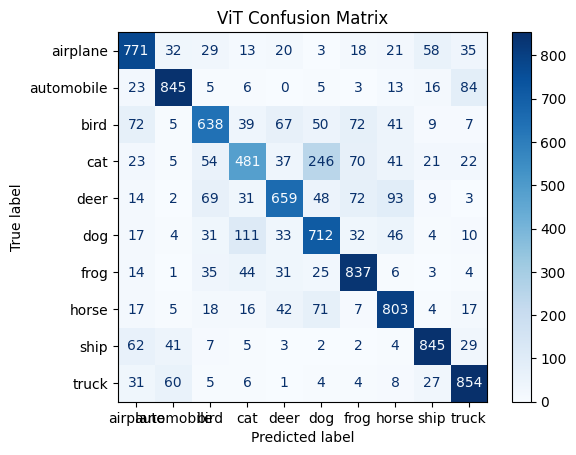

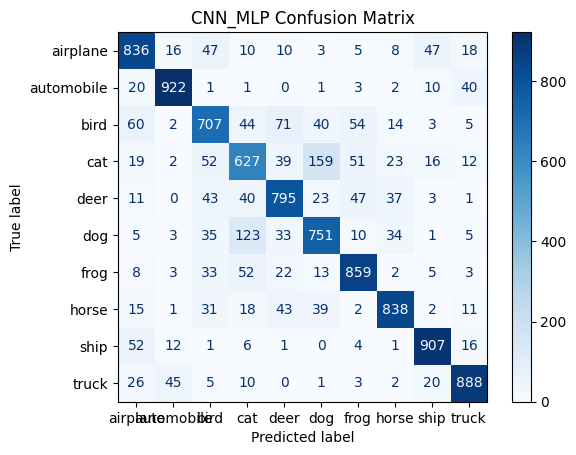

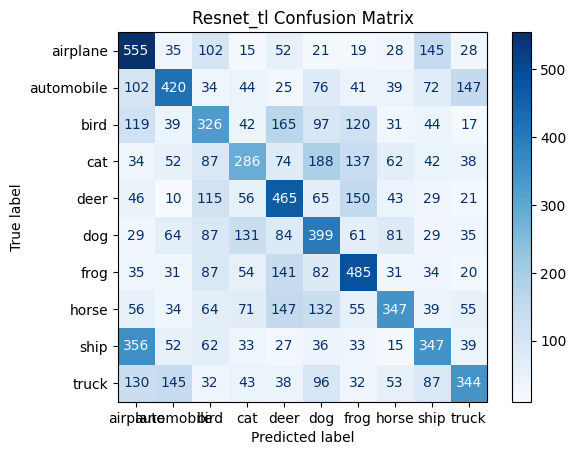

In [83]:
# Reloading best weights
vit.load_state_dict(torch.load('/kaggle/working/best_vit.pt'))
cnn_mlp.load_state_dict(torch.load('/kaggle/working/best_cnn_mlp.pt'))
resnet_tl.load_state_dict(torch.load('/kaggle/working/best_resnet.pt'))

# Evaluating
results = {}
for name, model in [('ViT', vit), ('CNN+MLP', cnn_mlp), ('ResNet', resnet_tl)]:
    results[name] = run_epoch(model, test_loader, nn.CrossEntropyLoss(), None)
    print(f"{name} Test Acc: {results[name]['acc']:.3f}  F1: {results[name]['f1']:.3f}")


# Confusion matrix for ViT
y_true, y_pred = [], []
vit.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        out = vit(imgs.to(device)).argmax(dim=1).cpu().numpy()
        y_pred.extend(out); y_true.extend(labels.numpy())
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=test_set.classes).plot(cmap=plt.cm.Blues)
plt.title("ViT Confusion Matrix")
plt.show()


# Confusion matrix for CNN_MLP
y_true, y_pred = [], []
cnn_mlp.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        out = cnn_mlp(imgs.to(device)).argmax(dim=1).cpu().numpy()
        y_pred.extend(out); y_true.extend(labels.numpy())
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=test_set.classes).plot(cmap=plt.cm.Blues)
plt.title("CNN_MLP Confusion Matrix")
plt.show()


# Confusion matrix for Resnet_tl
y_true, y_pred = [], []
resnet_tl.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        out = resnet_tl(imgs.to(device)).argmax(dim=1).cpu().numpy()
        y_pred.extend(out); y_true.extend(labels.numpy())
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=test_set.classes).plot(cmap=plt.cm.Blues)
plt.title("Resnet_tl Confusion Matrix")
plt.show()


## 7. Plot Training Curves:

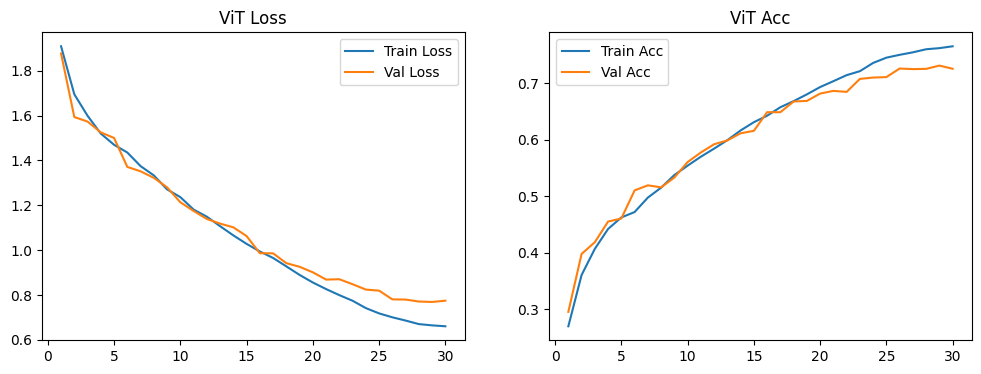

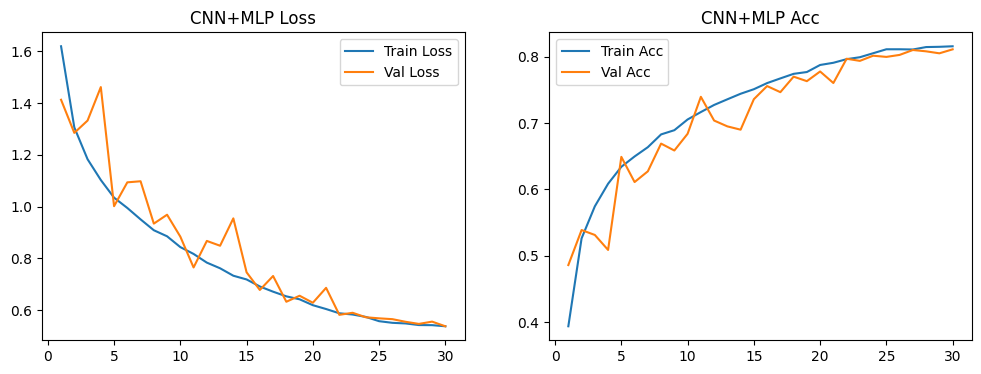

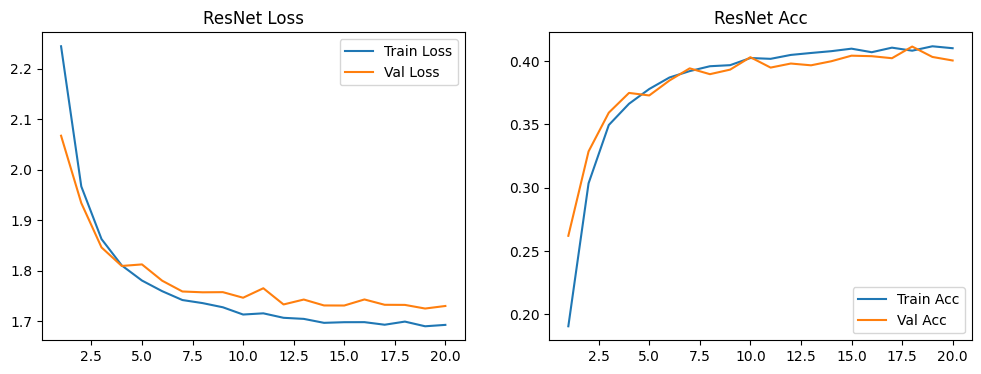

In [78]:
def plot_history(hist, name):
    epochs = range(1, len(hist)+1)
    tr_loss = [h[0]['loss'] for h in hist]
    val_loss= [h[1]['loss'] for h in hist]
    tr_acc  = [h[0]['acc']  for h in hist]
    val_acc = [h[1]['acc']  for h in hist]
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_loss,  label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss'); plt.legend(); plt.title(f'{name} Loss')
    plt.subplot(1,2,2)
    plt.plot(epochs, tr_acc,   label='Train Acc')
    plt.plot(epochs, val_acc,  label='Val Acc'); plt.legend(); plt.title(f'{name} Acc')
    plt.show()

plot_history(hist_vit,     'ViT')
plot_history(hist_cnn_mlp, 'CNN+MLP')
plot_history(hist_resnet,  'ResNet')


In [81]:
import time
import torch

def measure_inference_speed(model, loader, device, warmup_batches=5):
    """
    Returns (avg_ms_per_image, fps)
    """
    model.eval()
    timings = []

    # Warm-up:
    with torch.no_grad():
        for i, (imgs, _) in enumerate(loader):
            if i >= warmup_batches:
                break
            imgs = imgs.to(device)
            _ = model(imgs)

    # Actual timing
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            torch.cuda.synchronize()           
            start = time.time()
            _ = model(imgs)
            torch.cuda.synchronize()           
            end = time.time()
            timings.append((end - start) / imgs.size(0))  # seconds per image

    avg_sec_per_img = sum(timings) / len(timings)
    avg_ms_per_img  = avg_sec_per_img * 1e3
    fps             = 1.0 / avg_sec_per_img
    return avg_ms_per_img, fps


vit.to(device)
avg_ms, fps = measure_inference_speed(vit, test_loader, device)
print(f"VIT Inference Speed: {avg_ms:.2f} ms/img  —  {fps:.1f} FPS")

cnn_mlp.to(device)
avg_ms, fps = measure_inference_speed(cnn_mlp, test_loader, device)
print(f"CNN_MLP Inference Speed: {avg_ms:.2f} ms/img  —  {fps:.1f} FPS")

resnet_tl.to(device)
avg_ms, fps = measure_inference_speed(resnet_tl, test_loader, device)
print(f"Resnet_tl Inference Speed: {avg_ms:.2f} ms/img  —  {fps:.1f} FPS")

VIT Inference Speed: 0.17 ms/img  —  5863.4 FPS
CNN_MLP Inference Speed: 0.03 ms/img  —  29137.6 FPS
Resnet_tl Inference Speed: 0.08 ms/img  —  13281.5 FPS


## Deployment:

In [139]:
%%writefile streamlit_app2.py

import streamlit as st
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
from PIL import Image
from io import BytesIO
from torchvision.utils import make_grid
from torch import nn

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 d_model=256, nhead=4, num_layers=6, mlp_dim=512, dropout=0.1):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2             # total patches 
        self.patch_dim   = in_chans * patch_size * patch_size
        
        # Linear patch embedding
        self.patch_proj = nn.Linear(self.patch_dim, d_model)        
        
        # Class token + positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_emb   = nn.Parameter(torch.zeros(1, self.num_patches+1, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=mlp_dim,
            dropout=dropout, activation='gelu'
        )                                                              
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        
        # Splitting into patches
        patches = x.unfold(2, 4, 4).unfold(3, 4, 4)                   
        patches = patches.contiguous().view(B, 3, -1, 4, 4)          
        patches = patches.permute(0,2,1,3,4).reshape(B, -1, self.patch_dim)
        
        # Embedding patches and prepending class token
        x = self.patch_proj(patches)                                  
        cls_tokens = self.cls_token.expand(B, -1, -1)                
        x = torch.cat((cls_tokens, x), dim=1)                         
        x = x + self.pos_emb    
        
        # Transformer
        x = self.transformer(x.transpose(0,1)).transpose(0,1)
        
        # Classification
        return self.mlp_head(x[:,0])


class CNN_MLP(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )                                                            
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


# Loading models
@st.cache_resource
def load_models():
    
    # Vision Transformer
    vit = ViT().to(DEVICE)
    vit.load_state_dict(torch.load('/kaggle/working/best_vit.pt', map_location=DEVICE))
    vit.eval()
    
    # CNN+MLP
    cnn_mlp = CNN_MLP().to(DEVICE)
    cnn_mlp.load_state_dict(torch.load('/kaggle/working/best_cnn_mlp.pt', map_location=DEVICE))
    cnn_mlp.eval()
    
    # ResNet
    resnet = models.resnet18(pretrained=False)
    resnet.fc = nn.Linear(resnet.fc.in_features, 10)
    resnet.load_state_dict(torch.load('/kaggle/working/best_resnet.pt', map_location=DEVICE))
    resnet.to(DEVICE).eval()
    return vit, cnn_mlp, resnet

vit_model, cnn_model, res_model = load_models()

# CIFAR-10 test set (with normalization stats)
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
std  = torch.tensor([0.2470, 0.2435, 0.2616]).view(3,1,1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.flatten().tolist(), std.flatten().tolist())
])

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Sidebar: number of samples
num_samples = st.sidebar.slider('Number of test images', 5, 50, 16)
indices = np.random.choice(len(test_set), num_samples, replace=False)

# Helper: unnormalize tensor to PIL Image
def tensor_to_pil(img_tensor):
    img = img_tensor * std + mean        
    img = img.clamp(0,1)
    pil = transforms.ToPILImage()(img)
    return pil


# Collecting results
results = []
with torch.no_grad():
    for idx in indices:
        img_tensor, label = test_set[idx]
        input_tensor = img_tensor.unsqueeze(0).to(DEVICE)
        pv = vit_model(input_tensor).argmax(dim=1).item()
        pc = cnn_model(input_tensor).argmax(dim=1).item()
        pr = res_model(input_tensor).argmax(dim=1).item()
        results.append((img_tensor, label, pv, pc, pr))

class_names = test_set.classes


# Displaying
st.title('CIFAR-10 Model Comparison')
st.markdown('### Correct vs Incorrect Predictions')

for model_name in ['ViT', 'CNN+MLP', 'ResNet']:
    st.header(model_name)
    cols = st.columns(4)
    row = 0
    for img_tensor, label, pv, pc, pr in results:
        pred = {'ViT': pv, 'CNN+MLP': pc, 'ResNet': pr}[model_name]
        correct = (pred == label)
        
        # Converting normalized tensor back to image & resizing with nearest-neighbor
        pil_img = tensor_to_pil(img_tensor)
        display_img = pil_img.resize((128,128), resample=Image.NEAREST)
        
        # Caption
        caption = f"True: {class_names[label]}\nPred: {class_names[pred]}"
        if not correct:
            caption = f"**WRONG**\n{caption}"
            
        # Placing in grid
        col = cols[row % 4]
        col.image(display_img, width=128, use_container_width=False, caption=caption)
        row += 1
        if row % 4 == 0:
            cols = st.columns(4)
            row = 0


Overwriting streamlit_app2.py


In [ ]:
!ngrok authtoken abc

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [140]:
from pyngrok import ngrok

# Start a new ngrok tunnel
public_url = ngrok.connect(8000)

print("Ngrok public URL:", public_url)

Ngrok public URL: NgrokTunnel: "https://93e5-104-154-233-118.ngrok-free.app" -> "http://localhost:8000"


In [141]:
!streamlit run streamlit_app2.py --server.port 8000




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8000
  Network URL: http://172.19.2.2:8000
  External URL: http://104.154.233.118:8000

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/kaggle/working/streamlit_app2.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitr